# **TEST IF GDRIVE IS MOUNT**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd/content/drive/MyDrive/IBM/Flowers-Dataset/

/content/drive/MyDrive/IBM/Flowers-Dataset


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


In [10]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "/content/drive/MyDrive/IBM/Flowers-Dataset/"


# **IMAGE AUGMENTATION**

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale= 1./225,zoom_range= 0.2,horizontal_flip=True,vertical_flip=True)
test_datagen = ImageDataGenerator( rescale= 1./225)

In [8]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [86]:
x_train = train_datagen.flow_from_directory(r"/content/drive/MyDrive/IBM/Flowers-Dataset/flowers/",target_size=(50,50),
                                                   class_mode = "categorical",batch_size=24 )

Found 4317 images belonging to 5 classes.


In [73]:
x_test = test_datagen.flow_from_directory(r"/content/drive/MyDrive/IBM/Flowers-Dataset/flowers",target_size=(64,64),class_mode='categorical',batch_size=75)

Found 4317 images belonging to 5 classes.


In [58]:
x_train.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [74]:
x_test.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# **SPLIT DATASETS**

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 1 classes.
Using 3454 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 1 classes.
Using 863 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['flowers']


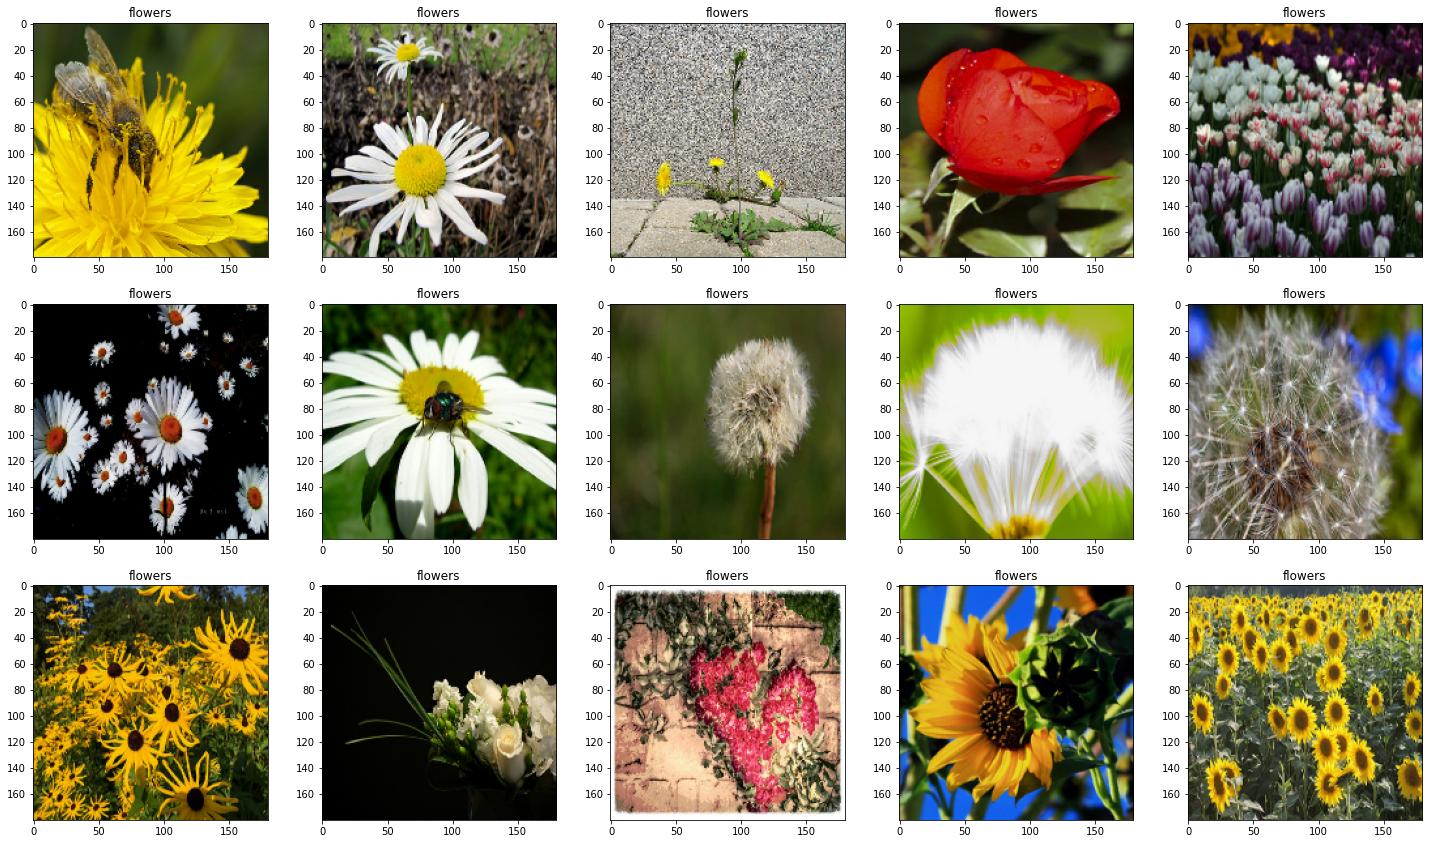

In [21]:
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

In [22]:
normalization_layer = layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[2]
# Notice the pixel values are now in `[1,2]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# **MODEL CREATION**

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
from tensorflow.keras.models import Sequential

In [80]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(64,64,3),activation = 'relu')) #Feature map
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


# **MODEL COMPILE**

In [38]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.compile(loss = "categorical_crossentropy",optimizer= "adam",metrics =['accuracy'])

In [50]:
len(x_train)

180

In [75]:
len(x_test)

58

In [62]:
def build_model():
  base_model = InceptionV3(input_shape=(resized_height, resized_width, num_channel), weights='imagenet', include_top=False, pooling='avg')
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(6, activation='softmax', name='final_classifier'))
  
  return model  

# **MODEL FIT**

In [92]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [135]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [137]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
108/108 [==============================] - 146s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
108/108 [==============================] - 148s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
108/108 [==============================] - 141s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
108/108 [==============================] - 139s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
108/108 [==============================] - 141s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Text(0.5, 1.0, 'Training and Validation Accuracy')

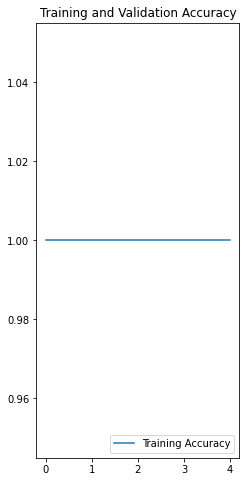

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



# **SAVE MODEL**

In [96]:
model.save('flowers.h5')

In [97]:
ls

flowers/  flowers.h5


# **TEST MODEL**

In [99]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('flowers.h5')

In [100]:
pwd

'/content/drive/MyDrive/IBM/Flowers-Dataset'

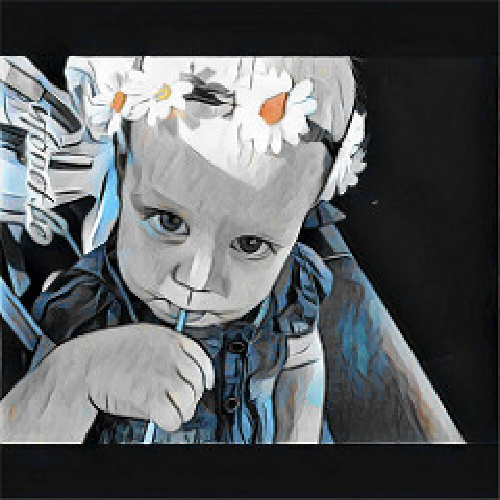

In [108]:
img=image.load_img(r'/content/drive/MyDrive/IBM/Flowers-Dataset/flowers/daisy/30001711132_eb0fd7b04c_n.jpg',target_size = (500,500))
img

In [109]:
x=image.img_to_array(img)
x

array([[[39., 40., 34.],
        [39., 40., 34.],
        [28., 28., 26.],
        ...,
        [26., 26., 26.],
        [61., 61., 61.],
        [61., 61., 61.]],

       [[39., 40., 34.],
        [39., 40., 34.],
        [28., 28., 26.],
        ...,
        [26., 26., 26.],
        [61., 61., 61.],
        [61., 61., 61.]],

       [[27., 28., 23.],
        [27., 28., 23.],
        [15., 15., 13.],
        ...,
        [12., 12., 12.],
        [47., 47., 47.],
        [47., 47., 47.]],

       ...,

       [[29., 25., 22.],
        [29., 25., 22.],
        [13., 13., 13.],
        ...,
        [ 9., 10., 12.],
        [42., 44., 43.],
        [42., 44., 43.]],

       [[61., 57., 54.],
        [61., 57., 54.],
        [45., 45., 45.],
        ...,
        [39., 41., 40.],
        [71., 73., 70.],
        [71., 73., 70.]],

       [[61., 57., 54.],
        [61., 57., 54.],
        [45., 45., 45.],
        ...,
        [39., 41., 40.],
        [71., 73., 70.],
        [71., 73., 70.]]

In [110]:
x.shape

(500, 500, 3)

In [111]:
x= np.expand_dims(x,axis=0)
x

array([[[[39., 40., 34.],
         [39., 40., 34.],
         [28., 28., 26.],
         ...,
         [26., 26., 26.],
         [61., 61., 61.],
         [61., 61., 61.]],

        [[39., 40., 34.],
         [39., 40., 34.],
         [28., 28., 26.],
         ...,
         [26., 26., 26.],
         [61., 61., 61.],
         [61., 61., 61.]],

        [[27., 28., 23.],
         [27., 28., 23.],
         [15., 15., 13.],
         ...,
         [12., 12., 12.],
         [47., 47., 47.],
         [47., 47., 47.]],

        ...,

        [[29., 25., 22.],
         [29., 25., 22.],
         [13., 13., 13.],
         ...,
         [ 9., 10., 12.],
         [42., 44., 43.],
         [42., 44., 43.]],

        [[61., 57., 54.],
         [61., 57., 54.],
         [45., 45., 45.],
         ...,
         [39., 41., 40.],
         [71., 73., 70.],
         [71., 73., 70.]],

        [[61., 57., 54.],
         [61., 57., 54.],
         [45., 45., 45.],
         ...,
         [39., 41., 40.],
        

In [112]:
x.shape

(1, 500, 500, 3)

In [116]:
index=['daisy','dandelion','rose','sunflower','tulip']

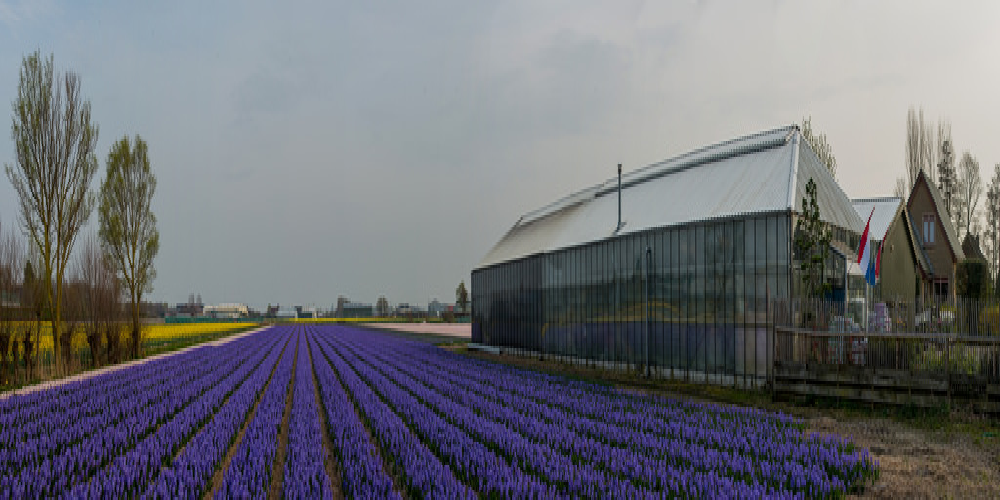

In [125]:
img=image.load_img(r'/content/drive/MyDrive/IBM/Flowers-Dataset/flowers/tulip/13555215723_cf2c11626b_b.jpg',target_size=(500,1000))
img

In [127]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)


In [128]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to flowers with a 100.00 percent confidence.
